In [131]:
from time import time
import lightgbm as lgb
import numpy as np
import sys
# sys.path.append('..\Python Scripts\pipeline')
import warnings
warnings.filterwarnings('ignore') 
import pickle
from sklearn.model_selection import KFold
import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, \
cross_val_score, GridSearchCV, validation_curve, KFold, GroupKFold
from sklearn.metrics import roc_auc_score
import gc
import yaml

In [139]:
main_path = r'../..'
data_path = main_path+'/data/'

%load_ext autoreload
%autoreload 2
import sys
sys.path.append(main_path)
from BayDS.lib.training import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
bad = yaml.load(open(r'f:\my\Prog\kaggle\Baydin\Snapshots\1\05-LabelEncoded-last\bad_for_training_features.yaml', 'r'), Loader=yaml.FullLoader)
bad.remove('DT_M')

# data = pd.read_pickle(r'f:\my\Prog\kaggle\Baydin\Snapshots\1\05-LabelEncoded-last\label_encoded_data.pkl')

data = pd.read_pickle(r'f:\my\Prog\kaggle\Baydin\Snapshots\1\06-LabelEncodingSuperLast\data.pkl')
data.drop(bad, axis=1, inplace=True)
data.drop(droplist, axis=1, inplace=True)
train = data[data['isFraud'] != -1]
test = data[data['isFraud'] == -1].drop('isFraud', axis=1)
y = data[data['isFraud'] != -1]['isFraud']

del data
gc.collect()

train.drop('isFraud', axis=1, inplace=True)

print(train.shape, test.shape)

train['start_date'] = pd.to_timedelta(pd.to_datetime(train['start_date'])).map(lambda x: x.days)
test['start_date'] = pd.to_timedelta(pd.to_datetime(test['start_date'])).map(lambda x: x.days)

for col in train.columns:
    if train[col].dtype == 'float64':
        print (col, train[col].dtype)
        train[col] = train[col].astype(np.float32)
        test[col] = test[col].astype(np.float32)

(590540, 707) (506691, 707)
TransactionAmt_by_new_card_id_ws1d_to_mean float64
TransactionAmt_by_new_card_id_ws1d_to_std float64
TransactionAmt_by_new_card_id_ws2d_to_mean float64
TransactionAmt_by_new_card_id_ws2d_to_std float64
TransactionAmt_by_new_card_id_ws3d_to_mean float64
TransactionAmt_by_new_card_id_ws3d_to_std float64
TransactionAmt_by_new_card_id_ws7d_to_mean float64
TransactionAmt_by_new_card_id_ws7d_to_std float64
TransactionAmt_by_new_card_id_ws30d_to_mean float64
TransactionAmt_by_new_card_id_ws30d_to_std float64
TransactionAmt_by_new_card_id_ws5_to_mean float64
TransactionAmt_by_new_card_id_ws5_to_std float64
TransactionAmt_by_new_card_id_ws10_to_mean float64
TransactionAmt_by_new_card_id_ws10_to_std float64
TransactionAmt_by_new_card_id_ws100_to_mean float64
TransactionAmt_by_new_card_id_ws100_to_std float64
C5_by_new_card_id_ws1d_to_mean float64
C5_by_new_card_id_ws2d_to_mean float64
C5_by_new_card_id_ws3d_to_mean float64
C5_by_new_card_id_ws7d_to_mean float64
C5_by_

In [144]:
train.shape

(590540, 707)

Fold 1 started at Tue Oct  1 00:08:00 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.999637	training's auc: 0.999637	valid_1's auc: 0.906441	valid_1's auc: 0.906441
[1000]	training's auc: 1	training's auc: 1	valid_1's auc: 0.914177	valid_1's auc: 0.914177
Early stopping, best iteration is:
[1039]	training's auc: 1	training's auc: 1	valid_1's auc: 0.914489	valid_1's auc: 0.914489
Fold 2 started at Tue Oct  1 01:31:15 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.999672	training's auc: 0.999672	valid_1's auc: 0.937752	valid_1's auc: 0.937752
[1000]	training's auc: 1	training's auc: 1	valid_1's auc: 0.94301	valid_1's auc: 0.94301
Early stopping, best iteration is:
[944]	training's auc: 1	training's auc: 1	valid_1's auc: 0.942704	valid_1's auc: 0.942704
Fold 3 started at Tue Oct  1 02:49:31 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.999603	training's a

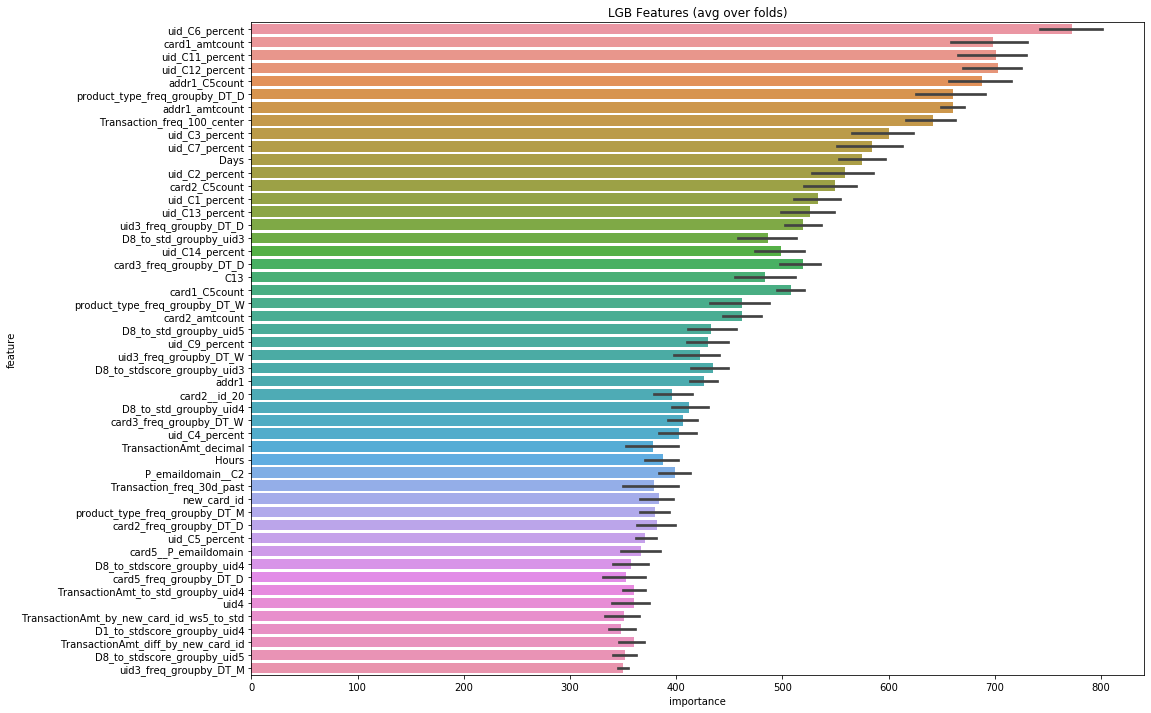

In [145]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'random_state': 7514, 
         }

n_fold = 6
folds = GroupKFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_new_dataset = train_model_classification(X=train.drop('DT_M', axis=1), X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=train['DT_M'])

In [146]:
pd.DataFrame(result_new_dataset['oof'], columns=['isFraud'], index=train.index).to_csv('oof_result_new_dataset_v2.csv')
pd.DataFrame(result_new_dataset['prediction'], columns=['isFraud'], index=test.index).to_csv('prediction_result_new_dataset_v2.csv')
pd.DataFrame(result_new_dataset['scores'], columns=['cv']).to_csv('scores_result_new_dataset_v2.csv')

sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_new_dataset['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('LGBT_i_want_to_sleep.csv')

Fold 1 started at Sun Sep 29 19:27:14 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.998865	training's auc: 0.998865	valid_1's auc: 0.906935	valid_1's auc: 0.906935
[1000]	training's auc: 0.999999	training's auc: 0.999999	valid_1's auc: 0.9128	valid_1's auc: 0.9128
[1500]	training's auc: 1	training's auc: 1	valid_1's auc: 0.915039	valid_1's auc: 0.915039
Early stopping, best iteration is:
[1314]	training's auc: 1	training's auc: 1	valid_1's auc: 0.914435	valid_1's auc: 0.914435
Fold 2 started at Sun Sep 29 20:21:03 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.998844	training's auc: 0.998844	valid_1's auc: 0.937546	valid_1's auc: 0.937546
[1000]	training's auc: 0.999999	training's auc: 0.999999	valid_1's auc: 0.941511	valid_1's auc: 0.941511
Early stopping, best iteration is:
[1277]	training's auc: 1	training's auc: 1	valid_1's auc: 0.942049	valid_1's auc: 0.942049
Fold 3 started at Sun Sep 29 21

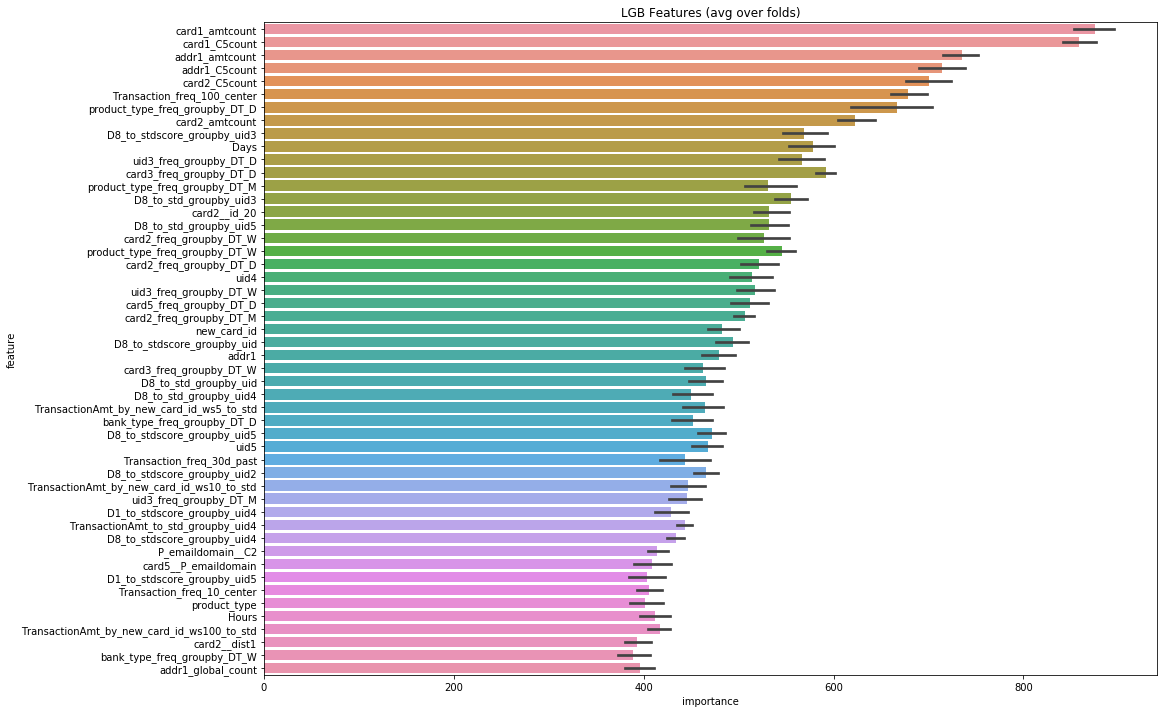

In [31]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 6
folds = GroupKFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_new_dataset = train_model_classification(X=train.drop('DT_M', axis=1), X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=train['DT_M'])

In [40]:
imps = result_new_dataset['feature_importance'].groupby('feature')[['importance']].agg('mean').sort_values(by='importance', ascending=False)

In [44]:
imps[imps['importance']>100].to_pickle('important_features.pkl')

In [47]:
imp = imps[imps['importance']>100].index

In [117]:
to_drop_imp = imps[imps['importance'] < 20].index.tolist()

In [76]:
def check_cor_and_remove(train_df, y, i_cols):

    print('#'*10)
    best_fe_columns = []
    train_df.replace(np.inf, np.nan, inplace=True)
    train_df.replace(-np.inf, np.nan, inplace=True)
    
    for col in i_cols:
        
        cor_cof = np.abs(np.corrcoef(y, train_df[col].fillna(0))[0][1])
        
        print(col, cor_cof)       
        
        best_fe_columns.append([col, cor_cof])


    return best_fe_columns

corrs = check_cor_and_remove(train, y, train.columns)

cordf = pd.DataFrame(corrs, columns=['feature', 'corr']).set_index('feature').sort_values(by='corr')

to_drop_corr = cordf[cordf['corr'] < 0.004].index.tolist()
to_drop_corrs = (set(to_drop_corr) - set(imp))

droplist = sorted(list(set(to_drop_imp) | set(to_drop_corrs)))

In [32]:
pd.DataFrame(result_new_dataset['oof'], columns=['isFraud'], index=train.index).to_csv('oof_result_new_dataset.csv')
pd.DataFrame(result_new_dataset['prediction'], columns=['isFraud'], index=test.index).to_csv('prediction_result_new_dataset.csv')
pd.DataFrame(result_new_dataset['scores'], columns=['cv']).to_csv('scores_result_new_dataset.csv')

sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_new_dataset['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('lgb_new_dataset.csv')

In [50]:
params = {'objective': 'binary',
          'max_depth': 10,
          'max_bin': 255,
          'learning_rate': 0.008,
          "boosting_type": "gbdt",
          "metric": 'auc',
          "verbosity": -1,
          'random_state': 7514, 
         }

n_fold = 6
folds = GroupKFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_new_dataset_v2 = train_model_classification(X=train.drop('DT_M', axis=1), X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=train['DT_M'])

Fold 1 started at Mon Sep 30 08:08:50 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.872019	training's auc: 0.872193	valid_1's auc: 0.824862	valid_1's auc: 0.82545
[1000]	training's auc: 0.88477	training's auc: 0.884801	valid_1's auc: 0.839215	valid_1's auc: 0.839444
[1500]	training's auc: 0.896	training's auc: 0.895998	valid_1's auc: 0.847969	valid_1's auc: 0.847961
[2000]	training's auc: 0.905815	training's auc: 0.905817	valid_1's auc: 0.856958	valid_1's auc: 0.856956
[2500]	training's auc: 0.914407	training's auc: 0.914407	valid_1's auc: 0.862155	valid_1's auc: 0.862158
[3000]	training's auc: 0.920539	training's auc: 0.920539	valid_1's auc: 0.867364	valid_1's auc: 0.867364
[3500]	training's auc: 0.925948	training's auc: 0.925948	valid_1's auc: 0.871384	valid_1's auc: 0.871384
[4000]	training's auc: 0.930832	training's auc: 0.930832	valid_1's auc: 0.875081	valid_1's auc: 0.875081
[4500]	training's auc: 0.934846	training's auc: 0.934846	val

[5500]	training's auc: 0.938803	training's auc: 0.938803	valid_1's auc: 0.905469	valid_1's auc: 0.905469
[6000]	training's auc: 0.940959	training's auc: 0.940959	valid_1's auc: 0.906705	valid_1's auc: 0.906705
[6500]	training's auc: 0.943095	training's auc: 0.943095	valid_1's auc: 0.908116	valid_1's auc: 0.908116
[7000]	training's auc: 0.945035	training's auc: 0.945035	valid_1's auc: 0.908981	valid_1's auc: 0.908981
[7500]	training's auc: 0.947188	training's auc: 0.947188	valid_1's auc: 0.910202	valid_1's auc: 0.910202
[8000]	training's auc: 0.949076	training's auc: 0.949076	valid_1's auc: 0.911243	valid_1's auc: 0.911243
[8500]	training's auc: 0.950684	training's auc: 0.950684	valid_1's auc: 0.912157	valid_1's auc: 0.912157
[9000]	training's auc: 0.952273	training's auc: 0.952273	valid_1's auc: 0.913156	valid_1's auc: 0.913156
[9500]	training's auc: 0.953756	training's auc: 0.953756	valid_1's auc: 0.914	valid_1's auc: 0.914
[10000]	training's auc: 0.955229	training's auc: 0.955229	val

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(result_new_dataset_v2['oof'], columns=['isFraud'], index=train.index).to_csv('oof_result_new_dataset_v2.csv')
pd.DataFrame(result_new_dataset_v2['prediction'], columns=['isFraud'], index=test.index).to_csv('prediction_result_new_dataset_v2.csv')
pd.DataFrame(result_new_dataset_v2['scores'], columns=['cv']).to_csv('scores_result_new_dataset_v2.csv')

sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_new_dataset_v2['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('lgb_new_dataset_v2.csv')

In [ ]:
params = {'objective': 'binary',
          'max_depth': 8,
          'max_bin': 255,
          'learning_rate': 0.001,
          "boosting_type": "gbdt",
          "metric": 'auc',
          "verbosity": -1,
          'random_state': 7514, 
         }

n_fold = 6
folds = GroupKFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_new_dataset_v3 = train_model_classification(X=train[x for x in imp if 'DT_M' not in imp], 
                                                   X_test=test[x for x in imp if 'DT_M' not in imp],
                                                   y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=train['DT_M'])

In [ ]:
pd.DataFrame(result_new_dataset_v3['oof'], columns=['isFraud'], index=train.index).to_csv('oof_result_new_dataset_v3.csv')
pd.DataFrame(result_new_dataset_v3['prediction'], columns=['isFraud'], index=test.index).to_csv('prediction_result_new_dataset_v3.csv')
pd.DataFrame(result_new_dataset_v3['scores'], columns=['cv']).to_csv('scores_result_new_dataset_v3.csv')

sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_new_dataset_v3['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('lgb_new_dataset_v3.csv')